**Investigating Graph Node Embeddings**

Gian Favero | ECSE 556 | December 1st, 2023

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from helpers import *

First we load the .edge file associated with the “HumanNet Co-Expression of Human Genes (hn_HS_CX) network. The file will be cleaned up in such a way that only the relevant columns and values are kept.

In [4]:
edges_df = pd.read_csv('9606.hn_HS_CX.edge', sep='\t', header=None)
edges_df = edges_df.iloc[:, :3]
edges_df.columns = ['Node 1', 'Node 2', 'Weight']
print(edges_df.head())

            Node 1           Node 2    Weight
0  ENSG00000284589  ENSG00000276821  0.000008
1  ENSG00000284589  ENSG00000267534  0.000006
2  ENSG00000284589  ENSG00000178802  0.000006
3  ENSG00000284589  ENSG00000172772  0.000007
4  ENSG00000284589  ENSG00000167751  0.000008


Now we have to start forming the adjacency matrix that represents the network. We can get a set of every node in the network and then augment the dataset to ensure the network is undirected.

In [5]:
# Get set of all nodes
nodes = set(edges_df['Node 1'])
nodes = nodes.union(set(edges_df['Node 2']))

# Convert nodes to indices in edges_df
nodes_dict = dict(zip(nodes, range(len(nodes))))
edges_df['Node 1'] = edges_df['Node 1'].map(nodes_dict)
edges_df['Node 2'] = edges_df['Node 2'].map(nodes_dict)

# Initialize adjacency matrix
adj_mat = np.zeros((len(nodes), len(nodes)))

# Fill adjacency matrix
for i in tqdm(range(len(edges_df))):
    row = edges_df.iloc[i]
    adj_mat[int(row['Node 1']), int(row['Node 2'])] = row['Weight']

# If there are any self-loops, remove them
np.fill_diagonal(adj_mat, 0)

100%|██████████| 154387/154387 [00:08<00:00, 18188.24it/s]


In [6]:
# Adjust adjacency matrix to be symmetric, undirected
adj_mat = process_symmetric_entries(adj_mat)

# Find all subgraphs and get list of nodes that belong to subgraphs with less than 5 nodes
subgraphs = find_subgraphs(adj_mat)
nodes_remove = nodes_to_remove(subgraphs, 5)

# Remove nodes from adjacency matrix
adj_mat = np.delete(adj_mat, nodes_remove, axis=0)
adj_mat = np.delete(adj_mat, nodes_remove, axis=1)

# Remove nodes from nodes list
nodes = list(nodes)
nodes = [nodes[i] for i in range(len(nodes)) if i not in nodes_remove]
nodes_dict = dict(zip(nodes, range(len(nodes))))

# Normalize adjacency matrix by row
tr_mat = adj_mat / adj_mat.sum(axis=1, keepdims=True)

**RW No Restart**

Now, we initialize three random initial distribution vectors with only one non-zero entry. We run RW until convergence and output the final distributions to see if RW without restart preserves local information about the nodes.

In [7]:
# First random walk vector has only one entry of 1, rest are 0
rw_vec = np.zeros((tr_mat.shape[0], 1))
rw_vec1 = rw_vec
rw_vec1[0] = 1

rw_vec2 = rw_vec
rw_vec2[1500] = 1

rw_vec3 = rw_vec
rw_vec3[5000] = 1

vecs = [rw_vec1, rw_vec2, rw_vec3]

# Perform random walk until there is small change in vector
stat_dist_no_restart = []
eps = 1e-5
for vec in tqdm(vecs):
    while True:
        rw_vec_new = tr_mat @ vec
        if np.linalg.norm(rw_vec_new - vec) < eps:
            break
        vec = rw_vec_new
    stat_dist_no_restart.append(rw_vec_new)

# See if the vectors are equal
are_close = np.allclose(stat_dist_no_restart[0], stat_dist_no_restart[1]) and \
            np.allclose(stat_dist_no_restart[0], stat_dist_no_restart[2]) and \
            np.allclose(stat_dist_no_restart[1], stat_dist_no_restart[2])
print('Are the vectors close? {}'.format(are_close))

100%|██████████| 3/3 [00:07<00:00,  2.61s/it]

Are the vectors close? True


**RW with Restart**

Now, we do a similar procedure as before but this time there is a chance on every iteration that the walk restarts from the beginning of its walk.

In [8]:
# Assign the restart nodes
N1 = int(edges_df['Node 1'].iloc[0])
v_N1 = np.zeros((tr_mat.shape[0], 1))
v_N1[N1] = 1

N2 = int(edges_df['Node 2'].iloc[0])
v_N2 = np.zeros((tr_mat.shape[0], 1))
v_N2[N2] = 1

Starting from an initial distribution, q0, we can find the stationary distribution when N1 and N2 are the restart set at different values of p

In [9]:
# Make list of p
p = [0.2, 0.5, 0.8]

# Make random initial distribution
q = np.zeros((tr_mat.shape[0], 1))
q[0] = 1

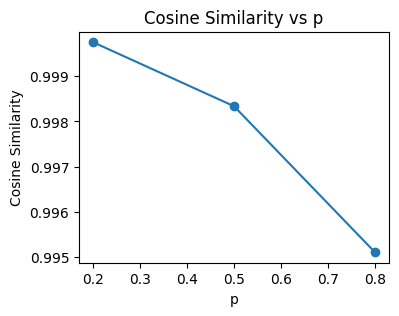

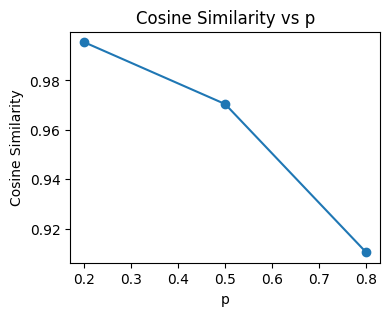

In [10]:
import matplotlib.pyplot as plt

for index, node in enumerate([v_N1, v_N2]):
    eps = 1e-5
    vec = q
    stat_dist_restart = []

    for p_i in p:
        while True:
            rw_vec_new = p_i * tr_mat @ vec + (1 - p_i) * node
            if np.linalg.norm(rw_vec_new - vec) < eps:
                break
            vec = rw_vec_new
        stat_dist_restart.append(rw_vec_new)

    # Put stationary distributions into a dataframe
    stat_dist_restart_df = pd.DataFrame(np.hstack(stat_dist_restart))
    stat_dist_restart_df.insert(0, 'Node', nodes)
    stat_dist_restart_df.columns = ['Node', 'p = 0.2', 'p = 0.5', 'p = 0.8']

    # Save stationary distributions to csv
    stat_dist_restart_df.to_csv(f'stat_dist_p_{index}.csv', index=False)

    # Compare stationary distributions to restart node 
    # Get cosine similarity between stationary distributions and restart node
    cos_sim = []
    for i in range(len(stat_dist_restart)):
        dot = np.dot(stat_dist_restart[i].T, node)
        norm1 = np.linalg.norm(stat_dist_restart[i])
        norm2 = np.linalg.norm(node)
        cosine_similarity = dot / (norm1 * norm2)
        cos_sim.append(cosine_similarity.item())

    # Plot cosine similarity vs p
    plt.figure(figsize=(4, 3))
    plt.plot(p, cos_sim, '-o')
    plt.xlabel('p')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity vs p')
    plt.show()

We can also observe what happens when a different initial distribution is picked but p is held fixed 

In [11]:
# Enforce constant p
p_fixed = 0.8

# Make 3 random initial distributions
q1 = np.zeros((tr_mat.shape[0], 1))
q2 = np.zeros((tr_mat.shape[0], 1))
q3 = np.zeros((tr_mat.shape[0], 1))

q1[0] = 1
q2[1500] = 1
q3[5000] = 1

qs = [q1, q2, q3]

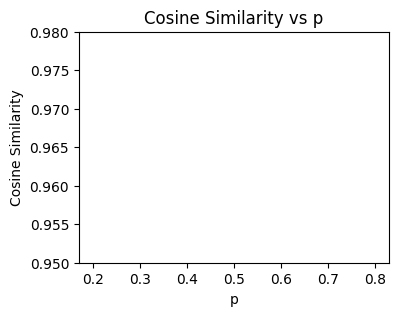

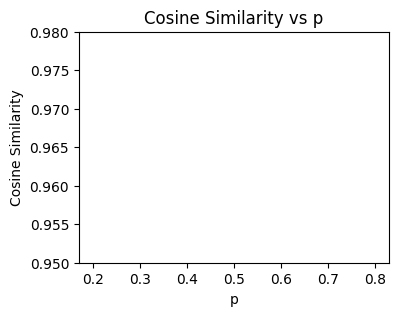

In [12]:
import matplotlib.pyplot as plt

for index, node in enumerate([v_N1, v_N2]):
    eps = 1e-5
    stat_dist_restart = []

    for q_i in qs:
        vec = q_i
        while True:
            rw_vec_new = p_fixed * tr_mat @ vec + (1 - p_fixed) * node
            if np.linalg.norm(rw_vec_new - vec) < eps:
                break
            vec = rw_vec_new
        stat_dist_restart.append(rw_vec_new)

    # Compare stationary distributions to restart node 
    # Get cosine similarity between stationary distributions and restart node
    cos_sim = []
    for i in range(len(stat_dist_restart)):
        dot = np.dot(stat_dist_restart[i].T, node)
        norm1 = np.linalg.norm(stat_dist_restart[i])
        norm2 = np.linalg.norm(node)
        cosine_similarity = dot / (norm1 * norm2)
        cos_sim.append(cosine_similarity.item())
    
    # Plot cosine similarity vs p
    plt.figure(figsize=(4, 3))
    plt.plot(p, cos_sim, '-o')
    plt.xlabel('p')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity vs p')
    plt.ylim(0.95, 0.98)
    
    plt.show()

Last, we can analyze the benefits of restart. Are the stationary distributions generated using N1 and N2 the same as they were with no restart?

In [13]:
# Enforce constant p
p_fixed = 0.2

# Enforce a random initial distribution
q_fixed = np.zeros((tr_mat.shape[0], 1))
q_fixed[0] = 1

In [14]:
eps = 1e-5
stat_dist_restart = []
vec = q_fixed

for index, node in enumerate([v_N1, v_N2]):
    while True:
        rw_vec_new = p_fixed * tr_mat @ vec + (1 - p_fixed) * node
        if np.linalg.norm(rw_vec_new - vec) < eps:
            break
        vec = rw_vec_new
    stat_dist_restart.append(rw_vec_new)

# Check if stationary distributions are equal
are_close = np.allclose(stat_dist_restart[0], stat_dist_restart[1])
print('Are the stationary distributions close? {}'.format(are_close))

# Get cosine similarity between stationary distributions
dot = np.dot(stat_dist_restart[0].T, stat_dist_restart[1])
norm1 = np.linalg.norm(stat_dist_restart[0])
norm2 = np.linalg.norm(stat_dist_restart[1])
cosine_similarity = dot / (norm1 * norm2)
print('Cosine similarity between stationary distributions: {}'.format(cosine_similarity[0][0]))

# Get cosine similarity between stationary distributions and restart node 1
for i in range(2):
    dot = np.dot(stat_dist_restart[i].T, v_N1)
    norm1 = np.linalg.norm(stat_dist_restart[i])
    norm2 = np.linalg.norm(v_N1)
    cosine_similarity = dot / (norm1 * norm2)
    print('Cosine similarity between stationary distribution {} and restart node 1: {}'.format(i, cosine_similarity[0][0]))

# Get cosine similarity between stationary distributions and restart node 2
for i in range(2):
    dot = np.dot(stat_dist_restart[i].T, v_N2)
    norm1 = np.linalg.norm(stat_dist_restart[i])
    norm2 = np.linalg.norm(v_N2)
    cosine_similarity = dot / (norm1 * norm2)
    print('Cosine similarity between stationary distribution {} and restart node 2: {}'.format(i, cosine_similarity[0][0]))

Are the stationary distributions close? False
Cosine similarity between stationary distributions: 2.8901143532262095e-05
Cosine similarity between stationary distribution 0 and restart node 1: 0.9997515108773479
Cosine similarity between stationary distribution 1 and restart node 1: 2.5831392700996118e-05
Cosine similarity between stationary distribution 0 and restart node 2: 8.936760360944837e-07
Cosine similarity between stationary distribution 1 and restart node 2: 0.9954283549466871


**Node2Vec**

We now get embeddings from a Node2Vec implementation

In [15]:
import networkx as nx
import node2vec

# Create graph from adjacency matrix
G = nx.from_numpy_matrix(adj_mat)

# Create node2vec model
depth_first = node2vec.Node2Vec(G, p=4, q=0.5, dimensions=len(nodes))
breadth_first = node2vec.Node2Vec(G, p=0.5, q=4, dimensions=len(nodes))

# Learn embeddings from walks
depth_first_model = depth_first.fit()
breadth_first_model = breadth_first.fit()

# Get depth-first embeddings for first two nodes
N1_depth_e = depth_first_model.wv[N1]
N2_depth_e = depth_first_model.wv[N2]

# Get breadth-first embeddings for first two nodes
N1_breadth_e = breadth_first_model.wv[N1]
N2_breadth_e = breadth_first_model.wv[N2]

# Get stationary distributions for first two nodes
N1_stat_dist = stat_dist_restart[0]
N2_stat_dist = stat_dist_restart[1]

Computing transition probabilities:   0%|          | 0/10825 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:35<00:00,  9.56s/it]


Computing transition probabilities:   0%|          | 0/10825 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:51<00:00, 11.12s/it]


In [ ]:
from scipy.stats import pearsonr, spearmanr

n1_embeddings = [N1_depth_e, N1_breadth_e, N1_stat_dist]
n2_embeddings = [N2_depth_e, N2_breadth_e, N2_stat_dist]

# Get Pearsons
n1_pearsons = []
n2_pearsons = []
for i in range(len(n1_embeddings)):
    for j in range(i + 1, len(n1_embeddings)):
        pearson = pearsonr(n1_embeddings[i], n1_embeddings[j])
        pearson = pearsonr(n2_embeddings[i], n2_embeddings[j])
        n1_pearsons.append(pearson[0])
        n2_pearsons.append(pearson[0])

# Get Spearmans
n1_spearmans = []
n2_spearmans = []
for i in range(len(n1_embeddings)):
    for j in range(i + 1, len(n1_embeddings)):
        spearman = spearmanr(n1_embeddings[i], n1_embeddings[j])
        spearman = spearmanr(n2_embeddings[i], n2_embeddings[j])
        n1_spearmans.append(spearman[0])
        n2_spearmans.append(spearman[0])

# Make dataframe of results for n1
n1_results = pd.DataFrame()
n1_results['Embedding 1'] = ['Depth-First', 'Breadth-First', 'Stationary Distribution']
n1_results['Embedding 2'] = ['Depth-First', 'Breadth-First', 'Stationary Distribution']
n1_results['Pearson'] = n1_pearsons
n1_results['Spearman'] = n1_spearmans

print(n1_results)

NameError: name 'N1_depth_e' is not defined

In [ ]:
''' Test code for adj matrix processing '''

'''# Define nodes and weights
node1 = ['A', 'B', 'C', 'D', 'B']
node2 = ['B', 'C', 'D', 'A', 'A']
weights = [1.0, 2.0, 3.0, 4.0, 5.0]

# Create dictionary
data = {'Node 1': node1, 'Node 2': node2, 'Weight': weights}

# Convert to DataFrame
test_df = pd.DataFrame(data)

print(test_df.head())

# Get set of all nodes
nodes = set(test_df['Node 1'])
nodes = nodes.union(set(test_df['Node 2']))

# Convert nodes to indices in edges_df
nodes_dict = dict(zip(nodes, range(len(nodes))))
test_df['Node 1'] = test_df['Node 1'].map(nodes_dict)
test_df['Node 2'] = test_df['Node 2'].map(nodes_dict)

print(test_df.head())

# Initialize adjacency matrix
test_adj = np.zeros((len(nodes), len(nodes)))

print(test_adj)

# Fill adjacency matrix
for i in range(len(test_df)):
    row = test_df.iloc[i]
    test_adj[int(row['Node 1']), int(row['Node 2'])] = row['Weight']

print(test_adj)

test_adj = process_symmetric_entries(test_adj)

print(test_adj)

# normalize adjacency matrix by row
test_adj = test_adj / test_adj.sum(axis=1, keepdims=True)

print(test_adj)'''

"# Define nodes and weights\nnode1 = ['A', 'B', 'C', 'D', 'B']\nnode2 = ['B', 'C', 'D', 'A', 'A']\nweights = [1.0, 2.0, 3.0, 4.0, 5.0]\n\n# Create dictionary\ndata = {'Node 1': node1, 'Node 2': node2, 'Weight': weights}\n\n# Convert to DataFrame\ntest_df = pd.DataFrame(data)\n\nprint(test_df.head())\n\n# Get set of all nodes\nnodes = set(test_df['Node 1'])\nnodes = nodes.union(set(test_df['Node 2']))\n\n# Convert nodes to indices in edges_df\nnodes_dict = dict(zip(nodes, range(len(nodes))))\ntest_df['Node 1'] = test_df['Node 1'].map(nodes_dict)\ntest_df['Node 2'] = test_df['Node 2'].map(nodes_dict)\n\nprint(test_df.head())\n\n# Initialize adjacency matrix\ntest_adj = np.zeros((len(nodes), len(nodes)))\n\nprint(test_adj)\n\n# Fill adjacency matrix\nfor i in range(len(test_df)):\n    row = test_df.iloc[i]\n    test_adj[int(row['Node 1']), int(row['Node 2'])] = row['Weight']\n\nprint(test_adj)\n\ntest_adj = process_symmetric_entries(test_adj)\n\nprint(test_adj)\n\n# normalize adjacency ma